In [1]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from multiprocessing import Pool
import rcca
from sklearn.cluster import KMeans
sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
import umap

### Paths

In [2]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'

### Read data

In [90]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
dataset='LINCS'

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'

nRep=2
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);


# l1k=mergProf_treatLevel[[pertColName,'det_plate']+l1k_features]
# cp=mergProf_treatLevel[[pertColName,'Metadata_Plate']+cp_features]

l1k=mergProf_treatLevel[[pertColName]+l1k_features]
cp=mergProf_treatLevel[[pertColName]+cp_features]


if dataset=='LINCS':     
    cp['Compounds']=cp['PERT'].str[0:13]
    l1k['Compounds']=l1k['PERT'].str[0:13]
else:
    cp['Compounds']=cp['PERT']
    l1k['Compounds']=l1k['PERT']      


le = preprocessing.LabelEncoder()
group_labels=le.fit_transform(l1k['Compounds'].values)


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))

#############################
cp_scaled['split']=''
cp_scaled.loc[cp_scaled['PERT'].isin(diverse_perts),'split']='train'
cp_scaled.loc[cp_scaled['PERT'].isin(test_perts),'split']='test'
cp_scaled.loc[cp_scaled['PERT']=='DMSO','split']='DMSO'

l1k_scaled['split']=''
l1k_scaled.loc[l1k_scaled['PERT'].isin(diverse_perts),'split']='train'
l1k_scaled.loc[l1k_scaled['PERT'].isin(test_perts),'split']='test'
l1k_scaled.loc[l1k_scaled['PERT']=='DMSO','split']='DMSO'

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.



LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
l1k n of rep:  3.0
cp n of rep:  5.0
CP: from  9394  to  4647
l1k: from  8369  to  2338
CP and l1k high rep overlap:  1140
Treatment Level Shapes (nSamples x nFeatures+metadata): (1141, 122) (1141, 980) Merged Profiles Shape: (1141, 1101)


<ipython-input-90-0c80cfd8dbb3>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-90-0c80cfd8dbb3>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
# merged_scaled=pd.concat([cp_shared, l1k_shared], axis=0)
# mergProf_treatLevel.shape
# mergProf_treatLevel[[pertColName,'Metadata_Plate']+cp_features]


### Apply Kernel CCA

In [92]:
# """Attributes:
# reg (float): regularization parameter. Default is 0.1.
# numCC (int): number of canonical dimensions to keep. Default is 10.
# kernelcca (bool): kernel or non-kernel CCA. Default is True.
# ktype (string): type of kernel used if kernelcca is True.
#                 Value can be 'linear' (default) or 'gaussian'.

# Create a cca object as an instantiation of the CCA object class. 
nComponents = 40

# cca = rcca.CCA(kernelcca = True, reg = 0, numCC = nComponents,ktype='gaussian')
cca = rcca.CCA(kernelcca = False,reg = 0, numCC = nComponents)

# Use the train() method to find a CCA mapping between the two training sets.
train=[cp_scaled[cp_features].values, l1k_scaled[l1k_features].values]
# train=[cp_scaled[cp_features].values[0:1000,:], l1k_scaled[l1k_features].values[0:1000,:]]
# test=[cp_scaled[cp_features].values[1000:,:], l1k_scaled[l1k_features].values[1000:,:]]
cca.train(train)

# Use the validate() method to test how well the CCA mapping generalizes to the test data.
# For each dimension in the test data, correlations between predicted and actual data are computed.
# testcorrs = cca.validate(test)
# print(testcorrs)


######################
cp_shared=pd.DataFrame(data=cca.comps[0],columns=range(nComponents))
cp_shared['PERT']=cp['PERT']
cp_shared['modality']='CP'
l1k_shared=pd.DataFrame(data=cca.comps[1],columns=range(nComponents))
l1k_shared['PERT']=l1k['PERT']
l1k_shared['modality']='GE'
merged_shared=pd.concat([cp_shared, l1k_shared], axis=0)


merged_shared['split']=''
merged_shared.loc[merged_shared['PERT'].isin(diverse_perts),'split']='train'
merged_shared.loc[merged_shared['PERT'].isin(test_perts),'split']='test'
merged_shared.loc[merged_shared['PERT']=='DMSO','split']='DMSO'

Training CCA, kernel = None, regularization = 0.0000, 40 components


In [62]:
testcorrs[0].shape,testcorrs[1].shape

((119,), (978,))

In [7]:
cp_scaled.shape

(26687, 122)

In [65]:
cca.corrs[0].shape,cca.corrs[1].shape

((119,), (978,))

In [70]:
# testcorrs[1],cca.corrs[1]

In [51]:
# # Initialize a cca object as an instantiation of the CCACrossValidate class.
# ccaCV = rcca.CCACrossValidate(kernelcca=True, numCCs = [10, 20, 30, 40,50,60,70,80],
#                               regs = [0.,1e1, 1e2,1e3, 1e4,1e5, 1e6])

# # Use the train() and validate() methods to run the analysis and perform cross-dataset prediction.
# ccaCV.train(train)
# # testcorrsCV = ccaCV.validate([test1, test2])
# print('Optimal number of components: %d\nOptimal regularization coefficient: %d' % (ccaCV.best_numCC, ccaCV.best_reg))

### Find best number of clusters on the shared space using elbow method

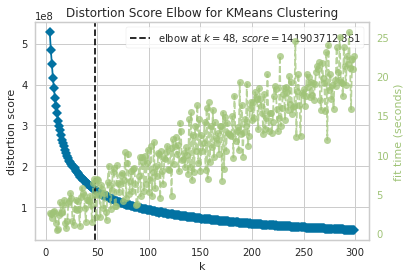

In [10]:

# from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# visualizer = KElbowVisualizer(
#     model, k=(10,200), metric='calinski_harabasz', timings=False
# )
visualizer = KElbowVisualizer(model, k=(4,300))

visualizer.fit(np.concatenate((cca.comps[0],cca.comps[1]),axis=0))        # Fit the data to the visualizer
visualizer.show()

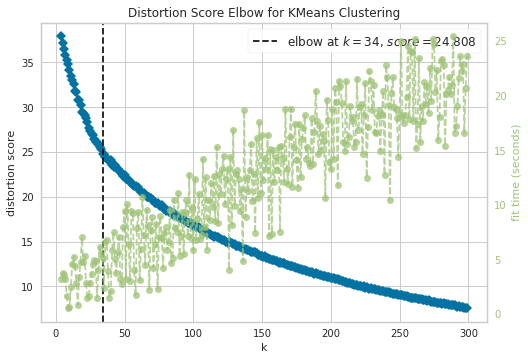

In [7]:
# from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# visualizer = KElbowVisualizer(
#     model, k=(10,200), metric='calinski_harabasz', timings=False
# )
visualizer = KElbowVisualizer(model, k=(4,300))

visualizer.fit(np.concatenate((cca.comps[0],cca.comps[1]),axis=0))        # Fit the data to the visualizer
visualizer.show()

In [15]:
cca.cancorrs

array([0.99952633, 0.9991287 , 0.999045  , 0.99883151, 0.99878574,
       0.99854218, 0.99837526, 0.99789709, 0.99768315, 0.99726901,
       0.99700127, 0.99694018, 0.99670009, 0.99647578, 0.99627516,
       0.99566296, 0.99527311, 0.99492095, 0.99448438, 0.99411987,
       0.99356919, 0.99330238, 0.99301449, 0.99231869, 0.99200171,
       0.99179008, 0.99140222, 0.99091464, 0.99025106, 0.98944365,
       0.98928351, 0.98866596, 0.98841669, 0.98742295, 0.98678126,
       0.98593765, 0.98577272, 0.98529234, 0.98408066, 0.98371255])

In [ ]:
np.concatenate((cca.comps[0],cca.comps[1]),axis=0)

In [109]:
np.concatenate((kmeans_cp.labels_,kmeans_cp.labels_),axis=0).shape

(2282,)

In [30]:
# merged_shared[range(nComponents)]
# cluster_labels.shape[0]/2
# merged_shared

### Apply kmeans using the found K

In [110]:
elbow_found_k=34
kmeans = KMeans(n_clusters=elbow_found_k, random_state=0).fit(merged_shared[range(nComponents)])
kmeans_cp = KMeans(n_clusters=elbow_found_k, random_state=0).fit(cp_scaled[cp_features].values)
kmeans_l1k = KMeans(n_clusters=elbow_found_k, random_state=0).fit(l1k_scaled[l1k_features].values)

cluster_labels=kmeans.labels_
merged_shared['cluster']=cluster_labels
merged_shared['cluster_cp']=np.concatenate((kmeans_cp.labels_,kmeans_cp.labels_),axis=0)
merged_shared['cluster_l1k']=np.concatenate((kmeans_l1k.labels_,kmeans_l1k.labels_),axis=0)

cp_cls_labels=cluster_labels[0:int(cluster_labels.shape[0]/2)]
l1k_cls_labels=cluster_labels[int(cluster_labels.shape[0]/2):]

diff_clust=cp_cls_labels-l1k_cls_labels
cca_approved_perts=list(cp_shared.PERT.values[np.where(diff_clust==0)])+['DMSO']

cp_scaled['cluster']=cp_cls_labels
l1k_scaled['cluster']=l1k_cls_labels

cp_scaled['cluster_cp']=kmeans_cp.labels_
l1k_scaled['cluster_cp']=kmeans_cp.labels_

cp_scaled['cluster_l1k']=kmeans_l1k.labels_
l1k_scaled['cluster_l1k']=kmeans_l1k.labels_

In [13]:
print(cp_cls_labels)
print(l1k_cls_labels)

[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]


In [30]:
# len(cca_approved_perts),
# cp_shared
# cca_approved_perts

In [39]:
# np.where(diff_clust==0)[0].shape
cp_shared.shape,merged_shared[merged_shared['modality']=='CP'].shape

((1141, 42), (1141, 45))

### Filter to the perts that fall into the same cluster

### Umap of Data in shared and original spaces for filtered samples

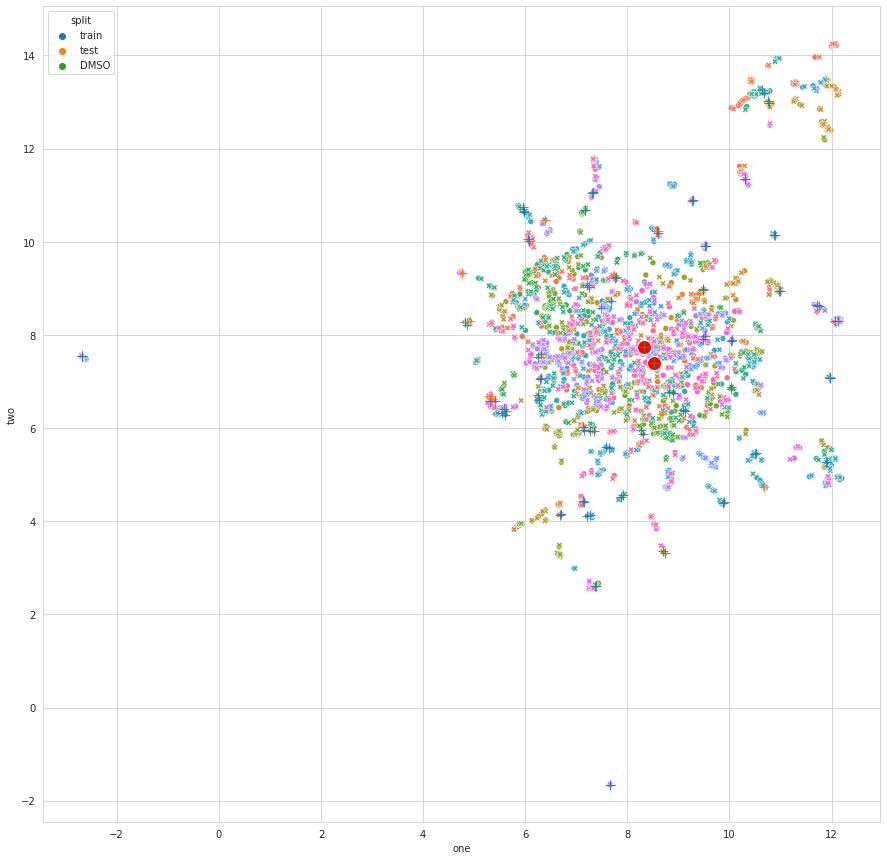

In [94]:
umapT=umap.UMAP()
Y = umapT.fit_transform(merged_shared[range(nComponents)])
merged_shared['one']=Y[:,0]
merged_shared['two']=Y[:,1]
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="PERT",style="modality", data=merged_shared,legend=False);
sns.scatterplot(x="one", y="two", data=merged_shared[merged_shared['PERT']=='DMSO'],color='r',s=200, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=merged_shared[merged_shared['split']!=''],s=100, marker="+");

# plt.show()

In [111]:
import plotly.express as px
fig = px.scatter(merged_shared, x="one", y="two",hover_data=['cluster','PERT','split','cluster_cp','cluster_l1k'],\
                 color="cluster",text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

In [55]:
merged_shared

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,PERT,modality,split
0,0.032143,0.001984,0.025263,0.031156,-0.053076,-0.000011,0.003857,-0.016341,0.019079,0.014572,...,-0.002389,0.015339,0.029464,0.057712,-0.040097,-0.032697,-0.019324,BRD-A03506276_0.04,CP,
1,0.027233,-0.033183,0.027916,0.019044,-0.040635,0.035824,-0.013775,-0.010556,0.017254,0.004672,...,0.031742,0.013483,0.005819,0.045233,-0.015958,-0.028320,-0.009497,BRD-A03506276_0.12,CP,
2,0.030151,-0.030145,0.018125,-0.001005,-0.038771,0.015504,0.014109,-0.009148,0.012118,-0.023731,...,0.013727,-0.001895,-0.007026,0.043616,-0.017196,-0.025929,-0.001308,BRD-A03506276_0.37,CP,train
3,0.000519,-0.012505,0.016787,0.006583,-0.040136,0.025434,0.000237,-0.022122,0.013793,-0.011918,...,0.032140,0.028918,0.021706,0.002314,-0.009919,-0.011879,0.019457,BRD-A03506276_1.11,CP,
4,0.002747,-0.009213,0.035509,0.003418,-0.038014,0.014909,0.006533,-0.010005,0.010095,-0.013265,...,0.001573,0.044457,0.022046,0.016598,0.011105,-0.006048,-0.010804,BRD-A03506276_3.33,CP,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,-0.018040,-0.011194,-0.000233,0.002888,0.017624,0.002982,-0.002377,0.011372,0.035180,-0.018896,...,0.019182,0.034740,0.011992,0.013265,0.022237,-0.020343,0.035831,BRD-K99792991_1.11,GE,
1137,-0.013982,-0.013180,-0.019223,0.013775,0.064553,0.026014,-0.000725,0.016858,0.056817,-0.055992,...,0.027483,0.042851,-0.009359,-0.021303,0.042595,-0.037780,-0.008053,BRD-K99792991_3.33,GE,
1138,0.001035,0.027335,-0.007079,-0.033109,0.001072,0.005242,0.008260,-0.003541,0.014610,-0.016621,...,0.013375,-0.004198,0.015009,0.028694,-0.024494,0.006405,0.000772,BRD-K99964838_3.33,GE,train
1139,0.004530,0.006509,0.003847,0.018144,0.011235,0.003785,0.014419,-0.010251,-0.011764,-0.000279,...,-0.017179,-0.022376,0.021624,0.014927,-0.006535,-0.011882,-0.008659,BRD-M80207679_3.33,GE,


In [ ]:
# 

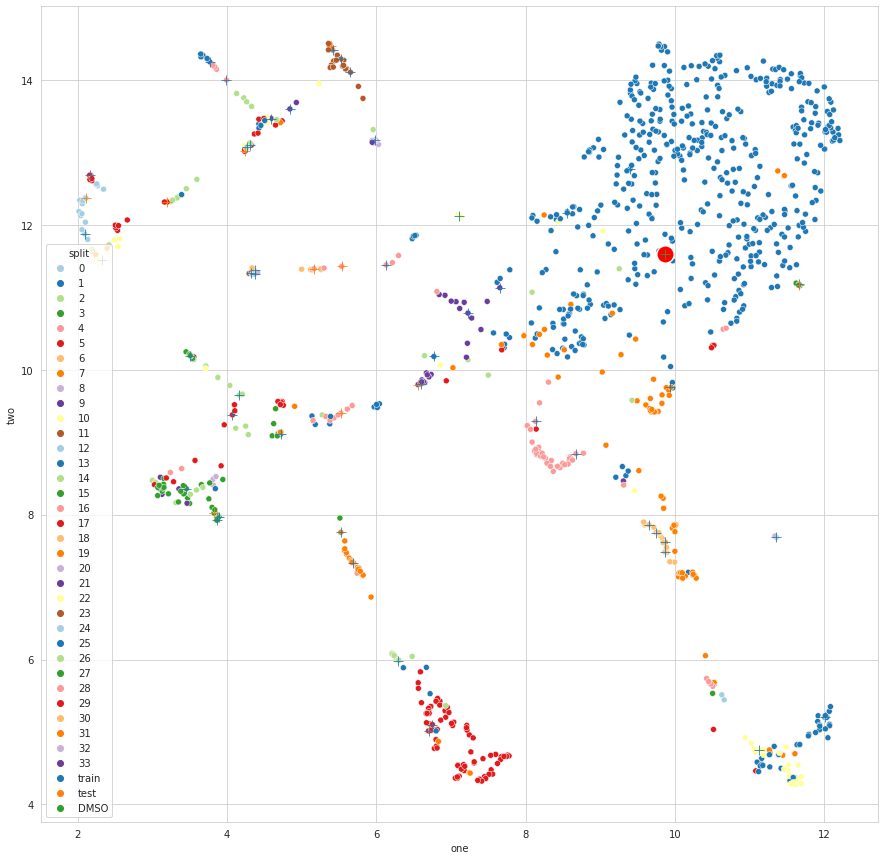

In [114]:
umapT=umap.UMAP()
cp_scaled_filtered=cp_scaled[cp_scaled['PERT'].isin(cca_approved_perts)].reset_index(drop=True)
Y = umapT.fit_transform(cp_scaled_filtered[cp_features])
cp_scaled_filtered['one']=Y[:,0]
cp_scaled_filtered['two']=Y[:,1]
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="cluster", data=cp_scaled_filtered,legend=True,palette='Paired');
sns.scatterplot(x="one", y="two", data=cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO'],color='r',s=300, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=cp_scaled_filtered[cp_scaled_filtered['split']!=''],s=100, marker="+");

In [ ]:
# sns.scatterplot(x="one", y="two", hue="cluster", data=cp_scaled_filtered,legend=True,palette='Paired');
# sns.scatterplot(x="one", y="two", data=cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO'],color='r',s=400, marker="o");


In [76]:
# cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO']

In [115]:
import plotly.express as px
fig = px.scatter(cp_scaled_filtered, x="one", y="two",hover_data=['cluster','cluster_cp','cluster_l1k','PERT'],color="cluster"\
                 ,text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

In [24]:
l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO']

,PERT,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,...,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at,Compounds,cluster,one,two


In [25]:
l1k_scaled_filtered['PERT']

0       BRD-A03506276_0.04
1       BRD-A03506276_0.12
2       BRD-A03506276_0.37
3       BRD-A03506276_1.11
4       BRD-A03506276_3.33
               ...        
1118    BRD-K99792991_0.04
1119    BRD-K99792991_1.11
1120    BRD-K99792991_3.33
1121    BRD-K99964838_3.33
1122    BRD-M80207679_3.33
Name: PERT, Length: 1123, dtype: object

In [67]:
%matplotlib widget
# g.legend(loc='right', bbox_to_anchor=(4, 0), ncol=1, borderaxespad=0.8)
# plt.subplots_adjust(right=.6)

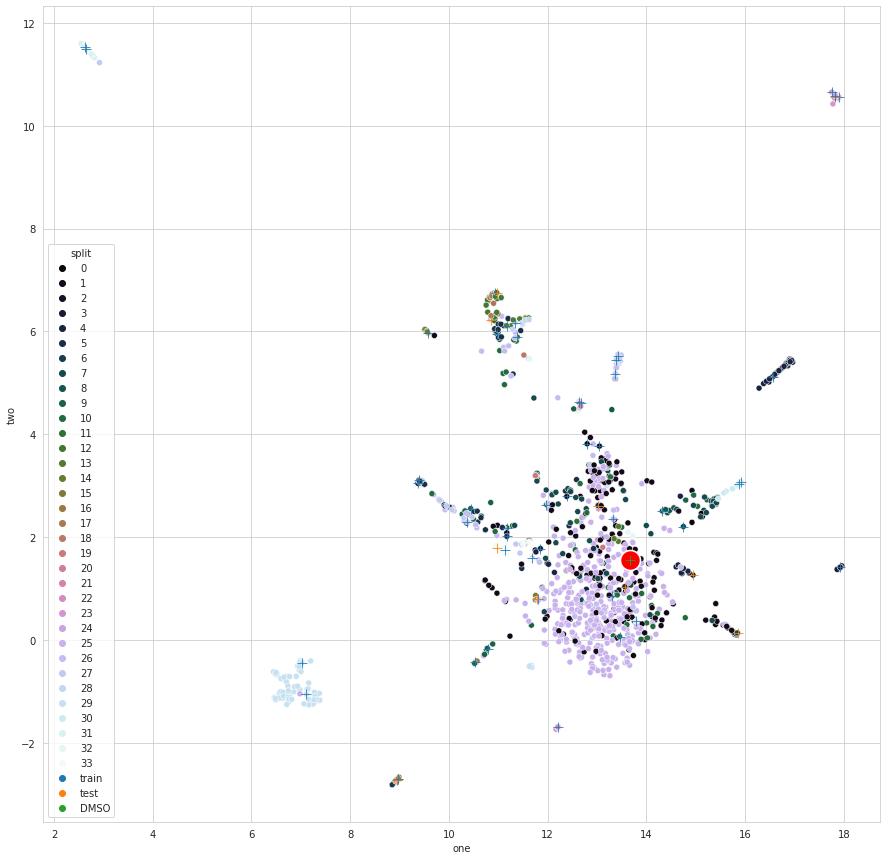

In [116]:
umapT=umap.UMAP()
l1k_scaled_filtered=l1k_scaled[l1k_scaled['PERT'].isin(cca_approved_perts)].reset_index(drop=True)
Y = umapT.fit_transform(l1k_scaled_filtered[l1k_features])
l1k_scaled_filtered['one']=Y[:,0]
l1k_scaled_filtered['two']=Y[:,1]
plt.figure(figsize=(15,15))
qualitative_colors = sns.color_palette("cubehelix", elbow_found_k)
sns.scatterplot(x="one", y="two", hue="cluster", data=l1k_scaled_filtered,legend=True,palette=qualitative_colors);
sns.scatterplot(x="one", y="two", data=l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'],color='r',s=400, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=l1k_scaled_filtered[l1k_scaled_filtered['split']!=''],s=100, marker="+");
plt.show()

In [76]:
# l1k_scaled_filtered

In [117]:
import plotly.express as px
fig = px.scatter(l1k_scaled_filtered, x="one", y="two",hover_data=['cluster','cluster_cp','cluster_l1k','PERT'],color="cluster"
                                 ,text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

# import plotly.express as px
# df = px.data.iris()
# fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
#                  size='petal_length', hover_data=['petal_width'])
# fig.show()

In [74]:
# l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO']
l1k_scaled_filtered

,PERT,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,...,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at,Compounds,cluster,one,two
0,BRD-A03506276_0.04,0.054523,-0.482228,-0.806310,-1.327158,-1.716060,-0.851952,-0.543062,-0.392722,0.448491,...,-0.548994,-1.066242,0.510051,1.070324,0.195922,0.253532,BRD-A03506276,23,21.568783,12.896956
1,BRD-A03506276_0.12,1.141985,-0.727375,-3.408594,-0.374784,-2.703976,0.426194,-0.690757,0.374699,-0.792572,...,-0.816935,-0.169793,-1.913725,0.326810,0.710607,0.804813,BRD-A03506276,23,15.522616,19.261158
2,BRD-A03506276_0.37,0.572380,-0.660839,0.493640,0.338325,-1.492509,0.880009,-1.386591,0.098619,0.439906,...,-0.895689,-0.348086,-2.866803,0.570141,0.115288,0.944758,BRD-A03506276,23,15.485964,19.297525
3,BRD-A03506276_1.11,0.738007,-0.778102,-2.854889,0.262467,-0.409593,-0.005442,-1.536147,-0.136520,0.093865,...,-0.701213,-0.969594,-1.802500,0.924460,0.450282,1.379227,BRD-A03506276,23,15.486565,19.297699
4,BRD-A03506276_3.33,0.707590,-1.025537,0.722153,1.096551,-1.069241,0.812125,-1.066386,-0.087608,0.408700,...,-0.848126,1.247304,-2.719211,1.061382,0.481658,1.059408,BRD-A03506276,23,15.496865,19.284521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,BRD-K99792991_1.11,0.428138,-0.715461,0.510105,-0.888243,0.172335,-0.203244,0.512200,0.904363,-0.432317,...,0.141287,2.216627,0.639118,-0.509325,-0.747019,-0.183856,BRD-K99792991,25,18.201382,14.198607
1120,BRD-K99792991_3.33,-0.438871,-1.021596,0.515111,-0.177112,-0.615662,0.164027,-0.015694,2.058672,-0.791508,...,1.447213,0.478087,0.830128,0.726887,0.816390,-0.333070,BRD-K99792991,19,17.851757,14.431182
1121,BRD-K99964838_3.33,-0.280160,-0.558763,0.157868,-0.956799,1.100288,0.261973,-0.413043,0.373012,-0.001723,...,0.325366,0.271173,-1.143960,0.415885,-0.657582,0.621562,BRD-K99964838,25,18.742132,13.041843
1122,BRD-M80207679_3.33,-0.966320,-0.360860,-1.457121,-1.108318,-0.484064,0.814508,-0.492581,-0.221665,-0.658722,...,-0.914742,0.778103,-0.215858,0.529523,1.316487,0.300046,BRD-M80207679,1,17.654356,12.664243


In [87]:
diverse_perts=['BRD-K86797399_3.33',
 'BRD-A56085258_3.33',
 'BRD-K68346641_0.12',
 'BRD-K60997853_0.37',
 'BRD-K00259736_0.12',
 'BRD-K78659596_0.37',
 'BRD-K76674262_0.37',
 'BRD-K83699324_1.11',
 'BRD-K43966364_1.11',
 'BRD-A27376179_0.37',
 'BRD-A75172220_0.12',
 'BRD-K23499943_3.33',
 'BRD-A94756469_3.33',
 'BRD-K22848513_3.33',
 'BRD-A05821830_1.11',
 'BRD-K61195623_0.12',
 'BRD-K99113996_0.37',
 'BRD-K79131256_0.37',
 'BRD-A66419424_3.33',
 'BRD-K41783120_1.11',
 'BRD-A03506276_0.37',
 'BRD-K99964838_3.33', # remove
 'BRD-K13662825_1.11',
 'BRD-K37890730_0.04',
 'BRD-K57080016_0.37',
 'BRD-K47869605_3.33',
 'BRD-K83837640_3.33',
 'BRD-K12867552_0.37',
 'BRD-A28467416_3.33',
 'BRD-K25630527_0.04',
 'BRD-K69776681_0.04',
 'BRD-K59317601_0.37',
 'BRD-K35245662_1.11',
 'BRD-K78055238_0.12',
 'BRD-K18157228_0.04',
 'BRD-K51967704_0.12',
 'BRD-K73088654_1.11',
 'BRD-A74914197_0.04',
 'BRD-K99475619_0.37',
 'BRD-K68488863_3.33',
 'BRD-K53417444_1.11',
 'BRD-K93779381_3.33',
 'BRD-K92428153_1.11',
 'BRD-K83963101_1.11',
 'BRD-K28822270_3.33',
 'BRD-K13183738_3.33',
 'BRD-K15108141_0.12',
 'BRD-K61397605_0.37',
 'BRD-A27376179_1.11']#,"DMSO"]

test_perts=['BRD-A28746609_0.37',  # multiple necleis
'BRD-K83837640_3.33',  # small cells
'BRD-K18157228_1.11',  #big and bright nucleolis
'BRD-K63750851_3.33',    # round but tiny eR dist around nucl
'BRD-K61195623_0.12',      # wiered
'BRD-K41783120_3.33', # sponge like ER network
'BRD-K41213548_3.33', # dotted mito
'BRD-K83837640_0.37', # stretched ER network
'BRD-K37764012_0.37', # one sided ER network
'BRD-K75295174_0.37', # dotted mito network
'BRD-K78567475_3.33']

In [40]:
# l1k_scaled[l1k_scaled['PERT'].isin(diverse_perts)][['PERT','cluster']]

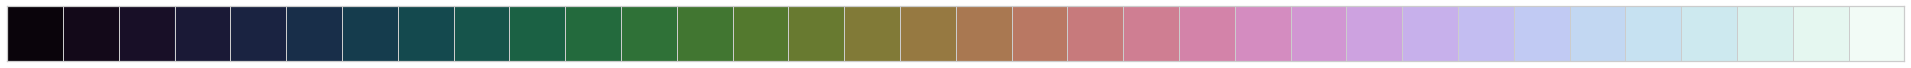

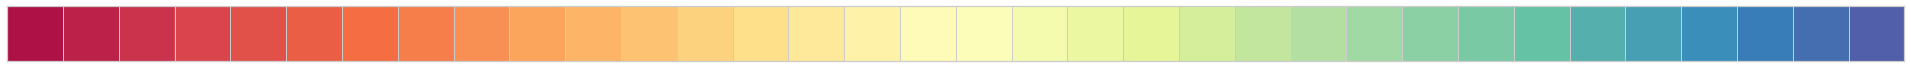

In [64]:
cls = sns.color_palette("cubehelix", elbow_found_k)
sns.palplot(cls)
cls = sns.color_palette("Spectral", elbow_found_k)
sns.palplot(cls)

In [119]:
perts_forModel=cp_scaled[cp_scaled['split']!=''].reset_index(drop=True)

In [120]:
perts_forModel.groupby(['cluster']).size()

cluster
1     4
2     1
3     1
4     3
5     4
6     1
7     1
8     1
9     4
10    3
11    1
12    2
13    1
14    1
15    2
16    3
17    1
18    1
22    1
23    4
24    1
25    1
26    2
27    5
28    1
29    2
30    2
31    2
32    1
33    2
dtype: int64

In [129]:
cluster_dmso,cluster_cp_dmso,cluster_l1k_dmso=perts_forModel[perts_forModel['PERT']=='DMSO'][['cluster','cluster_cp','cluster_l1k']].values[0]

In [136]:
perts_forModel_filtered_toNotIn_dmso_cluster=perts_forModel[~((perts_forModel['cluster']==cluster_dmso)|\
                                                            (perts_forModel['cluster_cp']==cluster_cp_dmso)|\
                                                           (perts_forModel['cluster_l1k']==cluster_l1k_dmso))]

In [156]:
pert_final=perts_forModel_filtered_toNotIn_dmso_cluster.groupby(['cluster']).sample(1).reset_index(drop=True)
pert_final.cluster_cp.unique().shape, pert_final.cluster_l1k.unique().shape

((24,), (21,))

In [161]:
pert_final2=perts_forModel_filtered_toNotIn_dmso_cluster.groupby(['cluster']).sample(1).reset_index(drop=True)
pert_final2.cluster_cp.unique().shape, pert_final2.cluster_l1k.unique().shape

((24,), (20,))

In [134]:
perts_forModel[(perts_forModel['cluster_cp']==cluster_cp_dmso)|\
                                                           (perts_forModel['cluster_l1k']==cluster_l1k_dmso)]

,PERT,Cells_AreaShape_Zernike_8_0,Cytoplasm_Correlation_Correlation_ER_RNA,Cytoplasm_Granularity_2_RNA,Nuclei_AreaShape_Zernike_4_4,Cytoplasm_AreaShape_Zernike_1_1,Nuclei_Texture_Correlation_RNA_20_0,Cytoplasm_Correlation_Overlap_ER_AGP,Nuclei_AreaShape_Zernike_2_0,Cytoplasm_Granularity_2_ER,...,Cytoplasm_Correlation_Overlap_DNA_RNA,Cells_Texture_InfoMeas2_DNA_20_0,Cells_RadialDistribution_RadialCV_ER_2of4,Nuclei_AreaShape_Zernike_6_6,Nuclei_AreaShape_Zernike_3_1,Compounds,split,cluster,cluster_cp,cluster_l1k
6,BRD-A56085258_3.33,-1.233798,0.060377,0.850872,0.46339,1.105543,0.391806,-0.650277,0.206452,0.899378,...,-0.179451,0.147078,0.845212,0.408384,0.598982,BRD-A56085258,train,1,33,8
58,DMSO,-0.453013,-0.428069,-0.001020,0.15598,0.463061,-0.176846,-0.402567,-0.265229,0.481473,...,-0.624534,-0.279998,0.605946,-0.074566,0.468998,DMSO,DMSO,1,33,1


In [165]:
pert_final_2=pert_final.groupby(['cluster_l1k']).sample(1).reset_index(drop=True)
pert_final_2.cluster_cp.unique().shape
# pert_final_2.groupby()

(21,)

In [166]:
pert_final_2

,PERT,Cells_AreaShape_Zernike_8_0,Cytoplasm_Correlation_Correlation_ER_RNA,Cytoplasm_Granularity_2_RNA,Nuclei_AreaShape_Zernike_4_4,Cytoplasm_AreaShape_Zernike_1_1,Nuclei_Texture_Correlation_RNA_20_0,Cytoplasm_Correlation_Overlap_ER_AGP,Nuclei_AreaShape_Zernike_2_0,Cytoplasm_Granularity_2_ER,...,Cytoplasm_Correlation_Overlap_DNA_RNA,Cells_Texture_InfoMeas2_DNA_20_0,Cells_RadialDistribution_RadialCV_ER_2of4,Nuclei_AreaShape_Zernike_6_6,Nuclei_AreaShape_Zernike_3_1,Compounds,split,cluster,cluster_cp,cluster_l1k
0,BRD-K83837640_3.33,2.645668,0.424556,-1.125311,0.106820,-5.147753,0.634509,-0.440095,1.733119,-1.735007,...,-0.492582,-1.472513,-1.492172,2.276666,1.297509,BRD-K83837640,test,16,11,2
1,BRD-K22848513_3.33,1.259975,-2.372661,-3.505776,-3.583603,-1.183637,-2.627658,2.436007,-6.574785,-2.830127,...,-1.206644,-6.053992,-1.361930,-0.891126,0.963401,BRD-K22848513,train,24,22,4
2,BRD-K76674262_0.37,3.113931,-1.595719,-1.921990,1.868607,0.712289,-1.751580,2.637029,1.151620,-0.646493,...,-0.139446,-0.458718,-2.873263,2.132138,0.332645,BRD-K76674262,train,14,32,6
3,BRD-K69776681_0.04,1.864913,0.065134,-1.658730,1.274533,-0.338129,1.741178,1.418326,1.228054,-2.238573,...,0.783466,1.762142,0.107528,2.704247,1.190562,BRD-K69776681,train,28,28,7
4,BRD-K61195623_0.12,1.240425,-1.361366,1.075223,-0.289011,0.129274,-0.317679,0.512093,-1.263966,-0.900213,...,0.969001,0.299321,-0.982531,1.532680,0.938831,BRD-K61195623,test,5,24,8
5,BRD-K13662825_1.11,1.607357,2.413673,-1.814731,-1.055691,2.771529,2.599213,-1.814647,-0.102547,-1.713413,...,-1.592324,1.205856,-0.934686,-0.207487,0.640713,BRD-K13662825,train,32,10,11
6,BRD-A28467416_3.33,0.015046,0.670783,0.724233,2.459991,-1.429372,-2.022450,0.056536,3.470911,2.593631,...,1.274539,-1.118066,-2.638391,0.981266,-2.726922,BRD-A28467416,train,30,23,12
7,BRD-K23499943_3.33,1.038328,1.492906,0.167824,-1.894269,-0.382228,0.713916,-0.770529,-0.865333,-0.956834,...,1.613866,0.472071,-0.850404,-0.719070,-1.627753,BRD-K23499943,train,23,16,13
8,BRD-A75172220_0.12,-0.622097,-0.678722,-1.669761,-0.286905,-0.084107,-1.911685,0.791211,0.216839,-0.402891,...,0.890607,-1.178570,-0.835726,-0.999877,-1.020022,BRD-A75172220,train,29,2,14
9,BRD-A28746609_0.37,0.121050,-0.576417,-0.937450,-0.536077,-1.839969,0.403140,1.750414,-0.256410,-1.239863,...,0.987187,0.717885,-2.299412,1.450750,0.732295,BRD-A28746609,test,26,9,15


In [167]:
pert_final_2.groupby(['split']).size()

split
test      4
train    17
dtype: int64

In [2]:
from IPython.display import display, Math, Latex

display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

In [169]:
pert_FINAL_list_22perts=pert_final_2.PERT.tolist()+['DMSO']

In [170]:
pert_FINAL_list_22perts

['BRD-K83837640_3.33',
 'BRD-K22848513_3.33',
 'BRD-K76674262_0.37',
 'BRD-K69776681_0.04',
 'BRD-K61195623_0.12',
 'BRD-K13662825_1.11',
 'BRD-A28467416_3.33',
 'BRD-K23499943_3.33',
 'BRD-A75172220_0.12',
 'BRD-A28746609_0.37',
 'BRD-K41783120_1.11',
 'BRD-K18157228_1.11',
 'BRD-K92428153_1.11',
 'BRD-K93779381_3.33',
 'BRD-K28822270_3.33',
 'BRD-K37890730_0.04',
 'BRD-K78659596_0.37',
 'BRD-K13183738_3.33',
 'BRD-K78055238_0.12',
 'BRD-A94756469_3.33',
 'BRD-K60997853_0.37',
 'DMSO']

### Given the final perturbation list for train and test:
   - Save the scaled profiles for CP and l1k
     - Each feature should be [0,1] range for each feature
   - Apply PCA on GE features and save them as well
   
   - Read single cell data and choose samples close to mean profile

